In [38]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import pynumdiff

import ekf

In [39]:
timeseries_length = 10
dt = 0.01
t = np.arange(0, timeseries_length, dt)

markersize = 4
linewidth = 0.75
positioncolor = 'cornflowerblue'
truecolor = 'black'
estimatecolor = 'red'

### Simulate

In [40]:
y, x, xdot, extras = pynumdiff.utils.simulate.pi_control(noise_parameters=(0, 0.1), 
                                                         timeseries_length=timeseries_length,
                                                         dt=dt)
hills, u = extras

### Nonlinear dynamics

In [41]:
# known parameters
mg = 10000 # mass*gravity
fr = 0.9 # friction
vd = 0.5 # desired velocity

# unknown parameters
true_ki = 5/0.01*dt # integral control
true_kp = 25/0.01*dt # proportional control

In [42]:
# process dynamics
def f(x, u):
    p, v, a, hill, integrator, ki, kp = x #np.ravel(x[:,-1])
    u1, u2 = u #np.ravel(u[:,-1])
    
    x_new = np.vstack((p + v*dt,
                      v + a*dt,
                      -fr*v -mg*hill +ki*integrator +kp*u2,
                      u1,
                      integrator + u2,
                      ki,
                      kp,
                      ))
    return x_new

# measurement dynamics
def h(x, u):
    y = np.vstack((x[0],
                   #x[3],
                   ))
    return y

In [43]:
def jacobian(f, x0, u0, epsilon=0.001):
    
    # Get A
    Aj = []
    for i in range(len(f(x0,u0))):
        
        def f_scalar(x,u,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]
        
        j = scipy.optimize.approx_fprime(x0, f_scalar, epsilon, u0, i)
        Aj.append(j)
        
    # Get B
    Bj = []
    for i in range(len(f(x0,u0))):
        
        def f_scalar(u,x,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]
        
        j = scipy.optimize.approx_fprime(u0, f_scalar, epsilon, x0, i)
        Bj.append(j)
    
    return np.matrix(np.vstack(Aj)), np.matrix(np.vstack(Bj))

### Set up parameters for filter

In [44]:
# process covariance
Q = np.matrix(1e-20*np.eye(7))
Q[5,5] = 1e-5
Q[6,6] = 1e-5

# measurement covariance
R = np.matrix(np.eye(1))
R[0,0] = 1e-5 #(.1)**2
#R[1,1] = 1e-16

P0 = 100*np.matrix(np.eye(7))

### Measurements and controls

In [45]:
u = np.matrix(u)
y_extended = np.matrix(np.vstack((y, hills[:, 0:-1])))

### Initial condition

In [46]:
x0 = np.matrix([0, 0, 0, hills[0,0], 0, 1, 1]).T
y = np.matrix(y)

In [47]:
u.shape

(2, 1000)

### Run filter

In [48]:
xhat, P, s = ekf.ekf(y, x0, f, h, Q, R, u, P0)

### Plot result

Text(0, 0.5, 'Position')

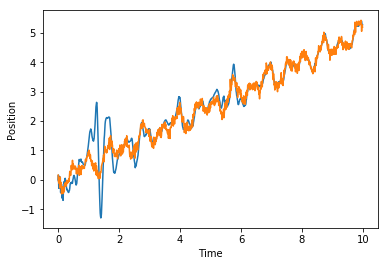

In [49]:
plt.plot(t, np.ravel(xhat[0,:]) )
plt.plot(t, np.ravel(y_extended[0]) )

plt.xlabel('Time')
plt.ylabel('Position')

Text(0, 0.5, 'Velocity')

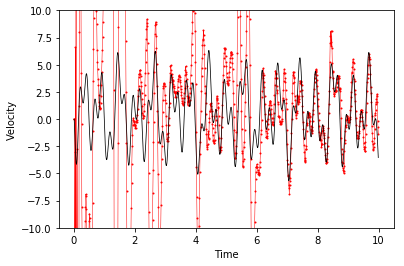

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)

xdothat = np.ravel(xhat[1,:])

ax.plot(t, xdothat, '.', markerfacecolor=estimatecolor, markeredgecolor='none', markersize=markersize, 
        rasterized=True)
ax.plot(t, xdothat, color=estimatecolor, linewidth=0.5, 
        rasterized=True)
ax.plot(t, xdot, color=truecolor, linewidth=linewidth)

plt.ylim(-10,10)

plt.xlabel('Time')
plt.ylabel('Velocity')

(-1, 6)

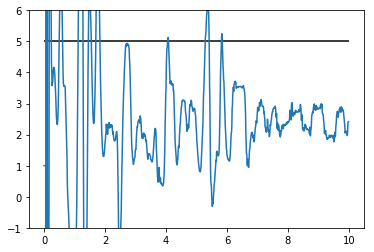

In [51]:
plt.plot(t, np.ravel(xhat[5,:]) )
plt.hlines(true_ki, 0, t[-1], colors='black')

plt.ylim(-1,6)

(0, 30)

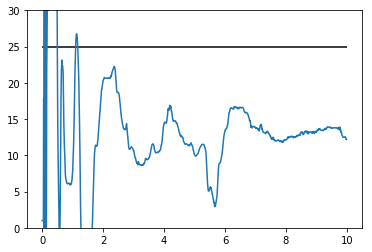

In [52]:
plt.plot(t, np.ravel(xhat[6,:]) )
plt.hlines(true_kp, 0, t[-1], colors='black')

plt.ylim(0,30)